In [1]:
import sys
sys.path.append('/home/linxuangao')  # 确保父目录在 Python 路径中

In [3]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import torch
import umap
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

from GPNSF.model import GPNSFModel
from GPNSF.utils import *


import warnings
warnings.filterwarnings("ignore")

/home/linxuangao/.conda/envs/glx/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
print(f'Using device: {device}')

Using device: cuda


In [5]:
data_dir = '/home/linxuangao/data_gpnsf/Dataset13_Simulation1'
adata1 = sc.read_h5ad(f'{data_dir}/adata_RNA.h5ad')
X_1 = adata1.layers['counts']
S = adata1.obsm['spatial']
spfac = adata1.obsm['spfac']
nsfac = adata1.obsm['nsfac']
spload_1 = adata1.varm['spload']
p = X_1.shape[1]
adata2 = sc.read_h5ad(f'{data_dir}/adata_ADT.h5ad')
X_2 = adata2.layers['counts']
spload_2 = adata2.varm['spload']
q = X_2.shape[1]

In [6]:
# 重新加载 GPNSF 并将 numpy/sparse 转为 torch 张量
from importlib import reload
import GPNSF.model as gp_model
reload(gp_model)
from GPNSF.model import GPNSFModel

import numpy as np
import scipy.sparse as sp

def to_torch_tensor(x, device, dtype=torch.float32):
    if hasattr(x, "toarray"):
        x = x.toarray()  # scipy.sparse -> ndarray
    if isinstance(x, np.ndarray):
        return torch.as_tensor(x, dtype=dtype, device=device)
    if isinstance(x, torch.Tensor):
        return x.to(device=device, dtype=dtype)
    raise TypeError(f"Unsupported type: {type(x)}")

S_t = to_torch_tensor(S, device, dtype=torch.float32)
X1_t = to_torch_tensor(X_1, device, dtype=torch.float32)
X2_t = to_torch_tensor(X_2, device, dtype=torch.float32)

print('Converted ->', 'S:', S_t.shape, 'X1:', X1_t.shape, 'X2:', X2_t.shape, 'device=', device)

Converted -> S: torch.Size([1296, 2]) X1: torch.Size([1296, 1000]) X2: torch.Size([1296, 100]) device= cuda


In [58]:
K = 4
M = 648

In [ ]:
from tqdm import tqdm
# 构建模型与训练循环（周期性打印 loss/ELBO/KL）
model = GPNSFModel(S=S_t, p=p, q=q, K=K, M=M, eta=50.0, num_mc_samples=3, likelihood_x2='nb', 
                   omega_type='chol', kernel_type='exp').to(device)

# 修改1: 初始学习率设为1e-3
opt = torch.optim.Adam(model.parameters(), lr=1e-3)  # 原为 lr=5e-4

@torch.no_grad()
def compute_loglik_terms(model, X1, X2):
    # 与模型内部保持一致的 Monte Carlo 估计，并适配 X2 的两种似然模式
    W1, W2 = model.get_W1_W2()
    theta1 = model.theta1
    Hs = model.sample_H()  # (S, n, K)
    loglik1 = []
    loglik2 = []
    if model.likelihood_x2 == 'nb':
        lambda2_nb = model.lambda2_nb
    else:
        lambda2_ber = model.lambda2_ber
        X2_bin = (X2 > 0).to(X2.dtype)
    for t in range(Hs.size(0)):
        H = Hs[t]
        Y1 = torch.exp(H) @ W1
        Y2 = torch.exp(H) @ W2
        loglik1.append(nb_log_prob(X1, Y1, theta1).sum())
        if model.likelihood_x2 == 'nb':
            loglik2.append(nb_log_prob(X2, Y2, lambda2_nb).sum())
        else:
            p2 = torch.clamp(Y2 * lambda2_ber, min=1e-8, max=1.0 - 1e-8)
            loglik2.append(bernoulli_log_prob(X2_bin, p2).sum())
    loglik1 = torch.stack(loglik1).mean()
    loglik2 = torch.stack(loglik2).mean()
    return loglik1, loglik2

num_steps = 10000
print_every = 500

# 修改2: 计算切换学习率的步数
switch_step = int(num_steps * 0.4)  # 前40%步数后切换

for step in tqdm(range(1, num_steps + 1), total=num_steps):
    opt.zero_grad()
    loss = model(X1_t, X2_t)  # 负ELBO
    loss.backward()
    opt.step()

    # 修改3: 在达到切换步数时降低学习率
    if step == switch_step:
        for param_group in opt.param_groups:
            param_group['lr'] = 5e-4
        print(f"\n[step {step:03d}] Learning rate changed to 5e-4")

    if step == 1 or step % print_every == 0:
        with torch.no_grad():
            elbo_val = model.elbo(X1_t, X2_t)
            kl_val = model.compute_KL_u()
            loglik1, loglik2 = compute_loglik_terms(model, X1_t, X2_t)
            current_lr = opt.param_groups[0]['lr']  # 添加显示当前学习率
            print(f"[step {step:03d}] loss={loss.item():.3f}  ELBO={elbo_val.item():.3f}  "
                  f"KL={kl_val.item():.3f}  loglik1={loglik1.item():.3f}  "
                  f"loglik2={loglik2.item():.3f}  lr={current_lr:.1e}")  # 添加学习率显示

print('Training finished.')

  0%|          | 2/10000 [00:00<14:51, 11.22it/s]

[step 001] loss=2888463.500  ELBO=-2887637.000  KL=989.956  loglik1=-2388928.500  loglik2=-449960.688  lr=1.0e-03


  5%|▌         | 504/10000 [00:21<06:13, 25.43it/s]

[step 500] loss=2446470.250  ELBO=-2445174.250  KL=571.364  loglik1=-2044690.750  loglik2=-369172.312  lr=1.0e-03


 10%|█         | 1002/10000 [00:41<06:10, 24.31it/s]

[step 1000] loss=2245975.000  ELBO=-2244775.750  KL=589.076  loglik1=-1874379.375  loglik2=-341713.750  lr=1.0e-03


 15%|█▌        | 1503/10000 [01:02<05:40, 24.97it/s]

[step 1500] loss=2133584.750  ELBO=-2133315.000  KL=601.074  loglik1=-1772089.750  loglik2=-331617.625  lr=1.0e-03


 20%|██        | 2004/10000 [01:23<05:54, 22.56it/s]

[step 2000] loss=2064767.250  ELBO=-2063679.250  KL=593.162  loglik1=-1707688.750  loglik2=-326772.625  lr=1.0e-03


 25%|██▌       | 2505/10000 [01:44<05:10, 24.12it/s]

[step 2500] loss=2020543.375  ELBO=-2020398.250  KL=591.101  loglik1=-1667375.250  loglik2=-322249.500  lr=1.0e-03


 30%|███       | 3004/10000 [02:05<04:35, 25.40it/s]

[step 3000] loss=1996102.625  ELBO=-1995916.000  KL=592.177  loglik1=-1647106.000  loglik2=-318976.000  lr=1.0e-03


 35%|███▌      | 3504/10000 [02:26<04:22, 24.76it/s]

[step 3500] loss=1983545.000  ELBO=-1983531.000  KL=594.590  loglik1=-1637459.750  loglik2=-316175.406  lr=1.0e-03


 40%|████      | 4002/10000 [02:47<04:28, 22.33it/s]


[step 4000] Learning rate changed to 5e-4
[step 4000] loss=1976791.625  ELBO=-1976153.625  KL=599.529  loglik1=-1633593.500  loglik2=-313972.031  lr=5.0e-04


 45%|████▌     | 4503/10000 [03:08<03:42, 24.75it/s]

[step 4500] loss=1975121.625  ELBO=-1975311.000  KL=602.341  loglik1=-1631906.000  loglik2=-312857.562  lr=5.0e-04


 50%|█████     | 5003/10000 [03:29<03:43, 22.31it/s]

[step 5000] loss=1973139.125  ELBO=-1973773.250  KL=604.844  loglik1=-1630556.750  loglik2=-311572.844  lr=5.0e-04


 55%|█████▌    | 5504/10000 [03:50<02:58, 25.17it/s]

[step 5500] loss=1972147.625  ELBO=-1971658.375  KL=606.748  loglik1=-1630033.875  loglik2=-311131.562  lr=5.0e-04


 60%|██████    | 6002/10000 [04:11<03:14, 20.58it/s]

[step 6000] loss=1971750.750  ELBO=-1971387.625  KL=608.089  loglik1=-1629876.000  loglik2=-310756.219  lr=5.0e-04


 65%|██████▌   | 6503/10000 [04:31<02:20, 24.80it/s]

[step 6500] loss=1969470.875  ELBO=-1969969.625  KL=608.933  loglik1=-1629217.750  loglik2=-310032.844  lr=5.0e-04


 70%|███████   | 7004/10000 [04:53<02:03, 24.36it/s]

[step 7000] loss=1969666.375  ELBO=-1969234.750  KL=609.361  loglik1=-1629215.250  loglik2=-309633.438  lr=5.0e-04


 75%|███████▌  | 7502/10000 [05:13<02:03, 20.24it/s]

[step 7500] loss=1968227.000  ELBO=-1968634.875  KL=609.450  loglik1=-1628454.000  loglik2=-309202.375  lr=5.0e-04


 80%|████████  | 8003/10000 [05:35<01:28, 22.60it/s]

[step 8000] loss=1967804.500  ELBO=-1968418.750  KL=609.279  loglik1=-1628360.000  loglik2=-308971.000  lr=5.0e-04


 85%|████████▌ | 8504/10000 [05:55<01:08, 21.97it/s]

[step 8500] loss=1967113.750  ELBO=-1967102.250  KL=609.348  loglik1=-1627943.000  loglik2=-308514.938  lr=5.0e-04


 90%|█████████ | 9002/10000 [06:16<00:45, 21.83it/s]

[step 9000] loss=1966380.625  ELBO=-1967306.250  KL=609.376  loglik1=-1628682.875  loglik2=-308696.000  lr=5.0e-04


 95%|█████████▌| 9502/10000 [06:38<00:26, 19.05it/s]

[step 9500] loss=1966478.000  ELBO=-1966718.500  KL=609.558  loglik1=-1628487.375  loglik2=-308111.812  lr=5.0e-04


100%|██████████| 10000/10000 [06:59<00:00, 23.86it/s]

[step 10000] loss=1966912.125  ELBO=-1966726.625  KL=610.074  loglik1=-1627106.875  loglik2=-307999.938  lr=5.0e-04
Training finished.


# 可视化 K 个空间分量（基于 q(H) 的均值）

下面两格：
- 先从模型的变分边缘 q(H) 提取每个因子在所有点的均值（并给出 exp(H) 版本）。
- 再在坐标 S 上绘制 K 个分量的热力图（支持 scatter/heatmap/combined）。

In [60]:
# 计算 q(H) 的均值并导出两种可视化矩阵：H_mu, H_exp
import numpy as np
import torch

with torch.no_grad():
    n = S_t.size(0)
    K_model = model.K
    H_mu = torch.empty(n, K_model, device=S_t.device, dtype=S_t.dtype)
    for k_idx in range(K_model):
        mu_k, _ = model.q_h_params(k_idx)  # (n,), (n,)
        H_mu[:, k_idx] = mu_k
    H_exp = torch.exp(H_mu)
    

print('H_mu/H_exp shapes ->', H_mu.shape, H_exp.shape)

# 转为 numpy，便于绘图
S_np = S_t.detach().cpu().numpy()
H_mu_np = H_mu.detach().cpu().numpy()
H_exp_np = H_exp.detach().cpu().numpy()

H_mu/H_exp shapes -> torch.Size([1296, 4]) torch.Size([1296, 4])


In [61]:
# 先删除所有以'Factor_'开头的列
factor_cols = [col for col in adata1.obs.columns if col.startswith('Factor_')]
adata1.obs = adata1.obs.drop(columns=factor_cols)


# row_norms = np.linalg.norm(H_exp_np, axis=1, keepdims=True)
# H_exp_np_normalized = H_exp_np / row_norms

row_sums = H_exp_np.sum(axis=1, keepdims=True)
H_exp_np_normalized = H_exp_np / row_sums


# row_sums = H_exp_np.sum(axis=1, keepdims=True)
# row_means = row_sums / H_exp_np.shape[1]
# threshold = 1 * row_means
# H_exp_np_filtered = np.where(H_exp_np < threshold, 0, H_exp_np)
# row_sums_filtered = H_exp_np_filtered.sum(axis=1, keepdims=True)
# H_exp_np_normalized = H_exp_np_filtered / row_sums_filtered


temp = pd.DataFrame(H_exp_np_normalized, columns=[f'Factor_{k+1}' for k in range(H_exp_np_normalized.shape[1])])
temp.index = adata1.obs.index
adata1.obs = adata1.obs.join(temp)

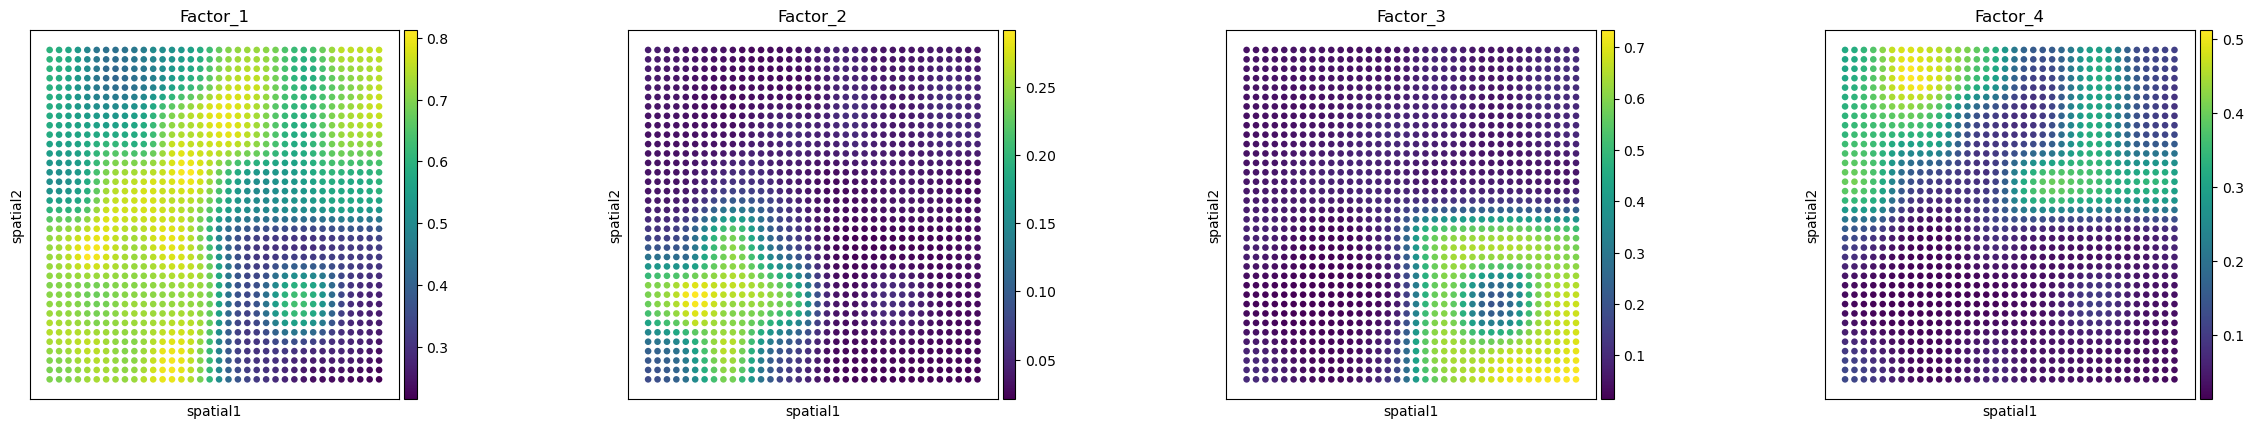

In [62]:
# 创建图形并保存
fig = sc.pl.spatial(
    adata=adata1,
    color=[f'Factor_{k+1}' for k in range(H_exp_np_normalized.shape[1])],
    spot_size=0.08,
    show=True  # 关键：不显示，只返回图形对象
)

# # 保存图片
# plt.savefig('sim_648_spatial_factors.png', 
#             dpi=300, 
#             bbox_inches='tight',  # 紧凑布局
#             facecolor='white')    # 背景色
# plt.close()  # 关闭图形，释放内存

In [51]:
# for i in range(adata1.obsm['spfac'].shape[1]):
#     adata1.obs[f'factor {i+1}'] = adata1.obsm['spfac'][:, i]

# sc.pl.spatial(adata1, color=[f'factor {i+1}' for i in range(adata1.obsm['spfac'].shape[1])], spot_size=0.1, save='sim_gt_spatial_factors')

In [52]:
# for i in range(adata1.obsm['nsfac'].shape[1]):
#     adata1.obs[f'factor {i+1}'] = adata1.obsm['nsfac'][:, i]

# sc.pl.spatial(adata1, color=[f'factor {i+1}' for i in range(adata1.obsm['nsfac'].shape[1])], spot_size=0.1, save='sim_gt_ns_factors')